Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1582e-04 - val_loss: 0.0011
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9693e-04 - val_loss: 0.0011
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1335e-04 - val_loss: 0.0011
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1005e-04 - val_loss: 0.0010
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7419e-04 - val_loss: 9.9732e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0949e-04 - val_loss: 0.0010
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6327e-04 - val_loss: 9.8483e-04
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8334e-04 - val_loss: 0.0011
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1476e-04 - val_loss: 9.6351e-04
Epoch 12/50
164

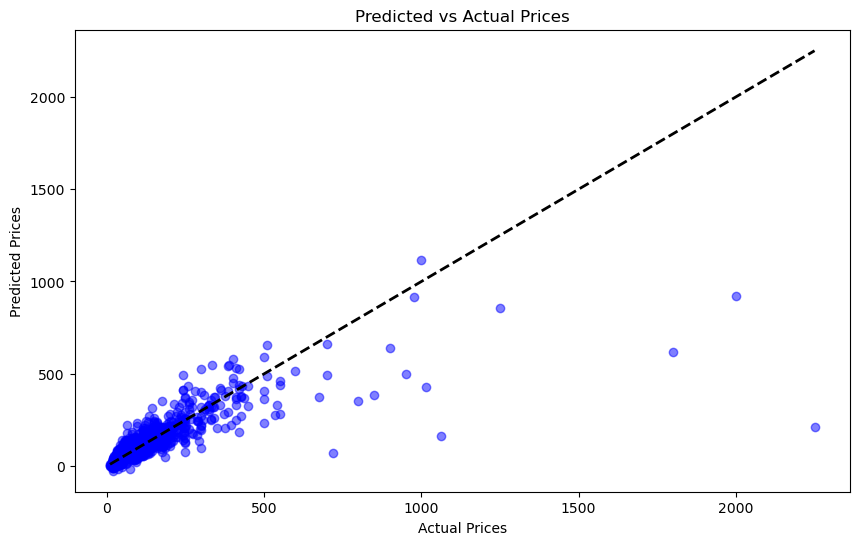

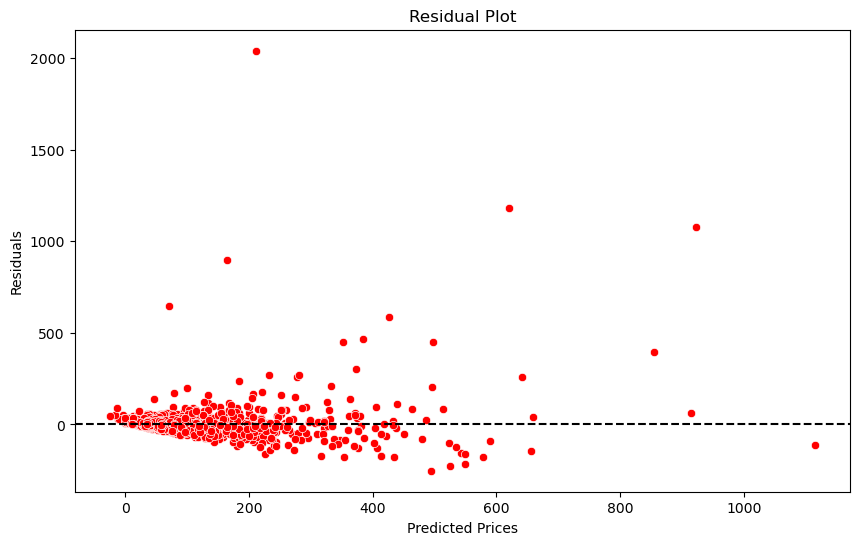

Mean Absolute Error: 26.445736411953558
Mean Squared Error: 5418.252445792873
Root Mean Squared Error: 73.60877967873719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
138.79912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
256.75134


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv("House_Data.csv")

# Data preprocessing (same as before)
data = data.dropna()

# Process location data (same as before)
location_count = data.groupby('location').size().sort_values(ascending=False)
location_less_10 = location_count[location_count <= 10]
data.location = data.location.apply(lambda x: 'other' if x in location_less_10 else x)

# Process BHK and area
data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data.total_sqft = data.total_sqft.apply(convert_sqft_to_num)
data = data[data.total_sqft.notnull()]

# Drop unnecessary columns
data = data.drop(['availability', 'society', 'size', 'area_type'], axis=1)

# One-hot encoding for location
dummies = pd.get_dummies(data.location)
data = pd.concat([data, dummies], axis=1)
data = data.drop(['location'], axis=1)

# Feature selection
X = data.drop('price', axis=1)
y = data['price']

# Normalize the data for LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data only to avoid data leakage
X_scaled = scaler_X.fit_transform(X)  # Scale the features
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Scale the target variable (price)

# Reshape X for LSTM [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))  # Using one LSTM layer
model.add(Dense(1))  # Output layer for price prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1)

# Make predictions
y_pred_scaled = model.predict(x_test)

# Inverse transform the predictions and test data
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inverse = scaler_y.inverse_transform(y_test)

# Predicted vs Actual Prices Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inverse, y_pred, c='blue', alpha=0.5)
plt.plot([y_test_inverse.min(), y_test_inverse.max()], [y_test_inverse.min(), y_test_inverse.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

# Residual Plot
residuals = y_test_inverse - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred.flatten(), y=residuals.flatten(), color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()

# Calculate error metrics
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test_inverse, y_pred)
mse = metrics.mean_squared_error(y_test_inverse, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Save the model
import pickle
with open('lstm_model.pkl', 'wb') as fh:
    pickle.dump(model, fh)

# Save column names for later use
index_dict = dict(zip(X.columns, range(X.shape[1])))
with open('cat', 'wb') as fid:
    pickle.dump(index_dict, fid, 2)

# Save location categories
location_list = list(zip(dummies.columns, range(X.shape[1])))
with open('location_cat', 'wb') as fid:
    pickle.dump(location_list, fid, 2)

# Prediction function using LSTM model
def predict(location, area, size, bath, balcony, total_sqft):
    input_data = np.zeros((1, X.shape[1]))  # 1D input, then reshape for LSTM

    # Fill in the feature values
    input_data[0, 0] = total_sqft
    input_data[0, 1] = bath
    input_data[0, 2] = balcony
    input_data[0, 3] = size

    # Handling location feature (One-Hot Encoding)
    if location in index_dict:
        input_data[0, index_dict[location]] = 1  # Set the relevant location to 1
    else:
        input_data[0, -1] = 1  # Use 'other' for locations not in training data

    # Scale the input data
    scaled_input = scaler_X.transform(input_data)  # Scaling the input
    scaled_input = scaled_input.reshape(1, 1, -1)  # Reshape for LSTM input

    # Predict the scaled price
    scaled_prediction = model.predict(scaled_input)

    # Inverse-transform the predicted price
    predicted_price = scaler_y.inverse_transform(scaled_prediction)[0][0]

    return predicted_price

# Example predictions
print(predict('Yelahanka', 'Carpet Area', 3, 3, 2, 3000))
print(predict('Yeshwanthpur', 'Carpet Area', 3, 3, 2, 3560))


In [10]:
predict('rajkot' , 'Carpet Area' , 3 , 3 , 3 ,2550)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


209.55891